In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')

from src.feature_engineering import FeatureEngineer


In [2]:
# Load preprocessed data
df = pd.read_csv('../data/processed/preprocessed_data.csv')
print(f"Data Shape: {df.shape}")
df.head()


Data Shape: (250000, 23)


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,15,6,483,0,1,4740,489.76,0.10,1990,...,35,10,3,High,No,0,"Playground, Gym, Garden, Pool, Clubhouse",3,2,0
1,2,11,33,434,1,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,1,"Playground, Clubhouse, Pool, Gym, Garden",1,1,1
2,3,13,25,75,0,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,0,"Clubhouse, Pool, Playground, Gym",2,0,0
3,4,14,21,326,1,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,1,"Playground, Clubhouse, Gym, Pool, Garden",1,1,0
4,5,14,19,407,2,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,1,"Playground, Garden, Gym, Pool, Clubhouse",0,1,0


In [3]:
# Initialize feature engineer
# growth_rate = 8% annual appreciation
feature_engineer = FeatureEngineer(growth_rate=0.08, current_year=2025)


In [4]:
# Engineer all features: coerce/encode object columns that may cause arithmetic errors
df_pre = df.copy()

# Binary mapping for Parking_Space (Yes/No) -> 1/0
if 'Parking_Space' in df_pre.columns:
	df_pre['Parking_Space'] = df_pre['Parking_Space'].map({'Yes': 1, 'No': 0}).fillna(df_pre['Parking_Space'])
	df_pre['Parking_Space'] = pd.to_numeric(df_pre['Parking_Space'], errors='coerce').fillna(0).astype(int)

# Ordinal mapping for Public_Transport_Accessibility
if 'Public_Transport_Accessibility' in df_pre.columns:
	pt_map = {'Low': 0, 'Medium': 1, 'High': 2}
	df_pre['Public_Transport_Accessibility'] = df_pre['Public_Transport_Accessibility'].map(pt_map).fillna(df_pre['Public_Transport_Accessibility'])
	df_pre['Public_Transport_Accessibility'] = pd.to_numeric(df_pre['Public_Transport_Accessibility'], errors='coerce').fillna(0).astype(int)

# Create Amenities_Count from comma-separated Amenities string
if 'Amenities' in df_pre.columns:
	df_pre['Amenities_Count'] = df_pre['Amenities'].fillna('').apply(lambda x: len([a for a in x.split(',') if a.strip()]))

# Ensure key numeric columns are numeric to avoid sequence * float errors
numeric_cols = ['Price_in_Lakhs', 'Price_per_SqFt', 'Size_in_SqFt', 'Year_Built', 'Age_of_Property']
for col in numeric_cols:
	if col in df_pre.columns:
		df_pre[col] = pd.to_numeric(df_pre[col], errors='coerce')

# Now safely engineer features
df_engineered = feature_engineer.engineer_all_features(df_pre)



🎨 STARTING FEATURE ENGINEERING
  ✓ Creating Price_per_SqFt feature
  ✓ Creating Age_of_Property feature
  ✓ Creating School_Density_Score feature
  ✓ Creating Infrastructure_Score feature
  ✓ Creating Amenities_Count feature
  ✓ Creating Floor_Ratio feature

📈 Creating REGRESSION Target: Future_Price_5Y
  ✓ Applied 8.0% annual growth for 5 years
  ✓ Average future price: ₹374.07 Lakhs

🎯 Creating CLASSIFICATION Target: Good_Investment
  ✓ Criterion 1 (Price ≤ median): 125017 properties
  ✓ Criterion 2 (Price/sqft ≤ median): 129047 properties
  ✓ Criterion 3 (BHK ≥ 2): 199804 properties
  ✓ Criterion 4 (Age < 10 years): 58851 properties
  ✓ Criterion 5 (Available/Under Construction): 0 properties

  📊 Good Investments: 94742 / 250000 (37.9%)

✅ FEATURE ENGINEERING COMPLETED


In [6]:
# Check new features
print("\n📋 New Features Created:")
new_features = [
    'Price_per_SqFt', 'Age_of_Property', 'School_Density_Score',
    'Infrastructure_Score', 'Amenities_Count', 'Floor_Ratio',
    'Future_Price_5Y', 'Good_Investment'
]

for feature in new_features:
    if feature in df_engineered.columns:
        print(f"  ✓ {feature}")

print(f"\n📊 Final Shape: {df_engineered.shape}")



📋 New Features Created:
  ✓ Price_per_SqFt
  ✓ Age_of_Property
  ✓ School_Density_Score
  ✓ Infrastructure_Score
  ✓ Amenities_Count
  ✓ Floor_Ratio
  ✓ Future_Price_5Y
  ✓ Good_Investment

📊 Final Shape: (250000, 29)


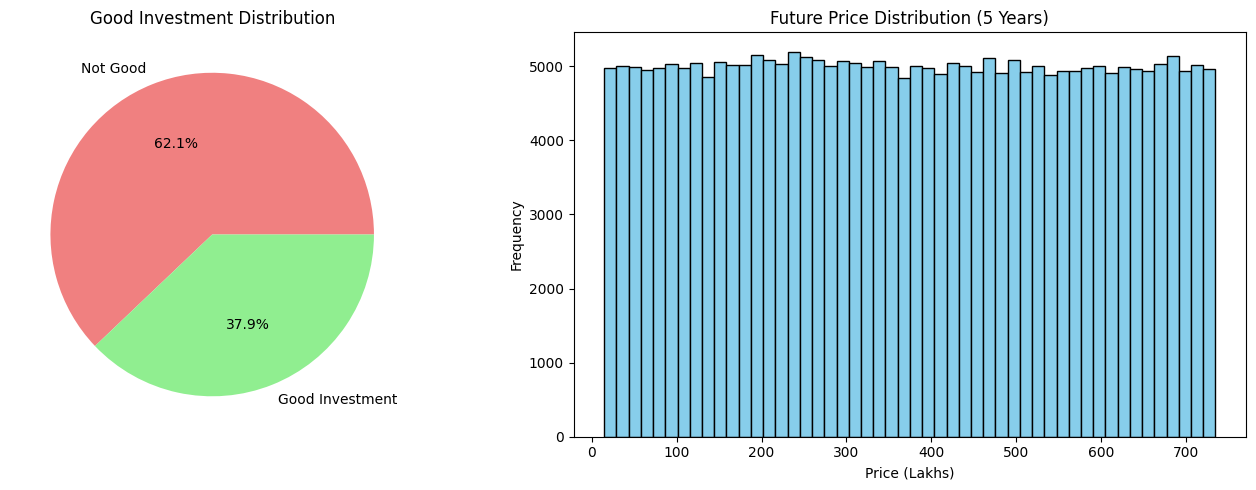

In [7]:
# Visualize targets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Classification target
axes[0].pie(
    df_engineered['Good_Investment'].value_counts(),
    labels=['Not Good', 'Good Investment'],
    autopct='%1.1f%%',
    colors=['lightcoral', 'lightgreen']
)
axes[0].set_title('Good Investment Distribution')

# Regression target
axes[1].hist(df_engineered['Future_Price_5Y'], bins=50, edgecolor='black', color='skyblue')
axes[1].set_title('Future Price Distribution (5 Years)')
axes[1].set_xlabel('Price (Lakhs)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


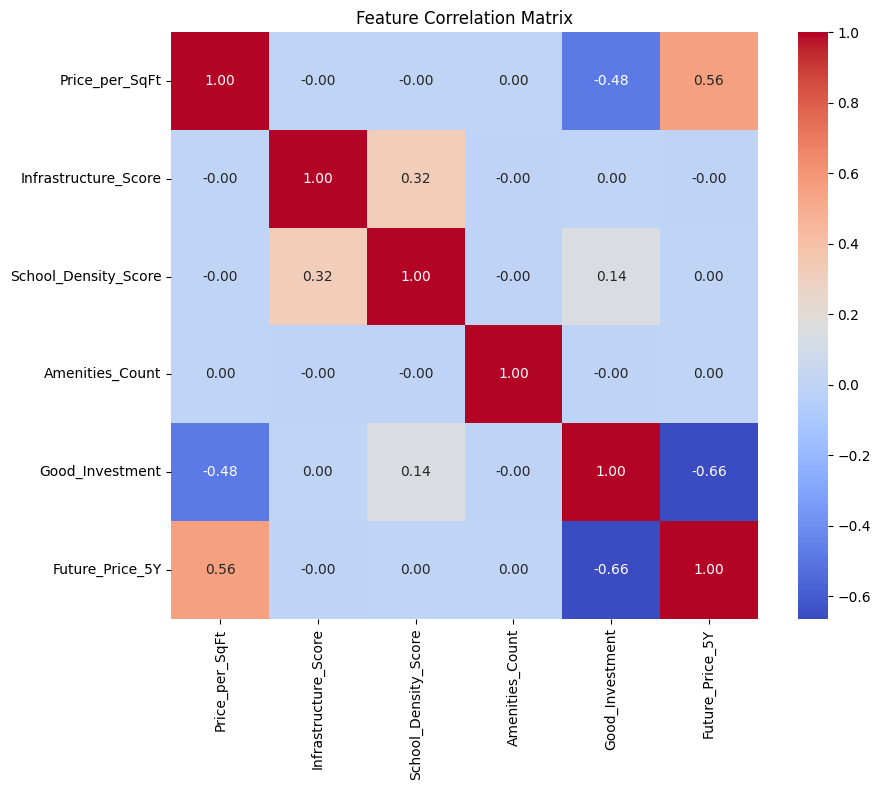

In [8]:
# Check correlation of new features with targets
features_to_check = [
    'Price_per_SqFt', 'Infrastructure_Score', 'School_Density_Score',
    'Amenities_Count', 'Good_Investment', 'Future_Price_5Y'
]

correlation = df_engineered[features_to_check].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [9]:
# Save engineered data
df_engineered.to_csv('../data/processed/engineered_data.csv', index=False)
print("\n✅ Engineered data saved to 'data/processed/engineered_data.csv'")



✅ Engineered data saved to 'data/processed/engineered_data.csv'
